In [1]:
from clawpack.pyclaw.solution import Solution
import numpy as np
import matplotlib.pyplot as plt
from clawpack import visclaw
from clawpack.visclaw.ianimate import ianimate
from nodepy import rk
import scipy.io
import os, sys
import scipy.integrate as integrate

#Import setup
from Num_Sol_2D_SWE import setup

### Exact solution

In [2]:
def d_int_h(x,y,t):
    return x*y*(6.0*t**2 - 0.5*x**2 - 0.5*y**2 + 6.0)/(3.0*t**4 + 6.0*t**2 + 3.0)

def d_int_hu(x,y,t):
    return t*x**2*y*(48.0*t**2 - 6.0*x**2 - 4.0*y**2 + 48.0)/(48.0*t**6 + 144.0*t**4 + 144.0*t**2 + 48.0)

def d_int_hv(x,y,t):
    return t*x*y**2*(24.0*t**2 - 2.0*x**2 - 3.0*y**2 + 24.0)/(24.0*t**6 + 72.0*t**4 + 72.0*t**2 + 24.0)

def Exact_Sol(X,Y,dx,dy,t):
    h_ex = (d_int_h(X+dx/2,Y+dy/2,t) + d_int_h(X-dx/2,Y-dy/2,t) - d_int_h(X+dx/2,Y-dy/2,t) - d_int_h(X-dx/2,Y+dy/2,t))/(dx*dy)
    hu_ex = (d_int_hu(X+dx/2,Y+dy/2,t) + d_int_hu(X-dx/2,Y-dy/2,t) - d_int_hu(X+dx/2,Y-dy/2,t) - d_int_hu(X-dx/2,Y+dy/2,t))/(dx*dy)
    hv_ex = (d_int_hv(X+dx/2,Y+dy/2,t) + d_int_hv(X-dx/2,Y-dy/2,t) - d_int_hv(X+dx/2,Y-dy/2,t) - d_int_hv(X-dx/2,Y+dy/2,t))/(dx*dy)
    
    return h_ex, hu_ex,hv_ex

In [3]:
def butcher_coeff(s,p,q,sch_no):
# Coefficients of Runge-Kutta method
#------------------------------#
    # Method 1: (3,3,1)
    if s == 3 and p == 3 and q == 1 and sch_no == 1:
        ssp33 = rk.loadRKM('SSP33')
        a = ssp33.A.astype('float64')
        b = ssp33.b.astype('float64')
        c = ssp33.c.astype('float64')
    # Method 2 (5,3,3)
    elif s == 5 and p == 3 and q == 3 and sch_no == 2:
#------------------------------#
        # Method 2: (5,3,3)
        a = np.array([[                  0,                 0,       0,              0,      0],
                      [               4/25,                 0,       0,              0,      0],
                      [       40646/132219,      47500/132219,       0,              0,      0],
                      [    -587499/3134080,     712975/626816,       0,              0,      0],
                      [ -12747373/12002547, 35703750/16635109, -90/731, 128000/3291693,      0]])

        b = np.array([24989/9120, -580625/144096, 103761/25840, -296720/76551, 43/20])
        c = np.sum(a,axis=1)
#------------------------------#
    # Method 3: (4,4,1)
    elif s == 4 and p == 4 and q == 1 and sch_no == 3:        
        rk4 = rk.loadRKM('RK44')
        a = rk4.A.astype('float64')
        b = rk4.b.astype('float64')
        c = rk4.c.astype('float64')
#------------------------------#
    # Method 4: (7,4,4)
    elif s == 7 and p == 4 and q == 4 and sch_no == 4:
        mat = scipy.io.loadmat('ExMthdAs7p4q4.mat') 
        a = np.array(mat['A']);b = np.array(mat['b'][0]);c = np.sum(a,axis=1)
#------------------------------#
    # Method 5: (7,5,1)
    elif s == 7 and p == 5 and q == 1 and sch_no == 5:
        dp5 = rk.loadRKM('DP5')
        a = dp5.A.astype('float64')
        b = dp5.b.astype('float64')
        c = dp5.c.astype('float64')
#------------------------------#
    # Method 5: (10,5,5)
    elif s == 10 and p == 5 and q == 5 and sch_no == 6: 
        mat = scipy.io.loadmat('ExMthdAs10p5q5.mat') 
        a = np.array(mat['A']);b = np.array(mat['b'].T)[0];c = np.sum(a,axis=1)
#------------------------------#
    return a,b,c

## Convergence test all methods

In [4]:
def compute_err(N, s, p, q, sch_no, tfinal, cfl):
    a,b,c = butcher_coeff(s,p,q,sch_no)
    errs_h = []; errs_hu = []; errs_hv = [];
    for idx in range(len(N)):
        print(N[idx])
        claw = setup(mx=N[idx],my=N[idx],a=a,b=b,c=c,tfinal=tfinal, cfl = cfl)
        claw.run()
        frame = claw.frames[-1]; 
        xc = frame.grid.x.centers; dx = xc[1]-xc[0]
        yc = frame.grid.y.centers; dy = yc[1]-yc[0]
        X, Y = frame.state.p_centers; t = frame.t
        # exact sol
        h_ex, hu_ex, hv_ex = Exact_Sol(X,Y,dx,dy,t)
        # Numerical solution
        num_h = frame.q[0]; num_hu = frame.q[1]; num_hv = frame.q[2];
        # Compute error 
        err_h = np.max(np.max(np.abs(num_h - h_ex)))
        err_hu = np.max(np.max(np.abs(num_hu - hu_ex)))
        err_hv = np.max(np.max(np.abs(num_hv - hv_ex)))
        errs_h.append(err_h); errs_hu.append(err_hu); errs_hv.append(err_hv)
    return errs_h, errs_hu, errs_hv

In [6]:
N = np.array([30,40,50,60,70,80,90,100]);  
tfinal=0.5; cfl = 0.8; dts = cfl*(1./N)/2; 
S = [3,5,4,7,7,10];P =[3,3,4,4,5,5]; Q =[1,3,1,4,1,5]; SCH_NO = [1,2,3,4,5,6]
Err_u = np.zeros((len(SCH_NO),len(N)))
Err_hu = np.zeros((len(SCH_NO),len(N)))
Err_hv = np.zeros((len(SCH_NO),len(N)))

for i in range(len(SCH_NO)):
    print("(Method = (%d,%d,%d))"%(S[i], P[i], Q[i]))
    errs_h, errs_hu, errs_hv = compute_err(N, S[i], P[i], Q[i], SCH_NO[i], tfinal, cfl)
    Err_u[i,:] = errs_h; Err_hu[i,:] = errs_hu; Err_hv[i,:] = errs_hv

(Method = (3,3,1))
30
2023-09-05 12:32:24,287 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:32:24,340 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-05 12:32:24,385 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-05 12:32:24,431 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-05 12:32:24,475 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-05 12:32:24,519 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-05 12:32:24,565 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-05 12:32:24,612 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-05 12:32:24,658 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-05 12:32:24,702 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-05 12:32:24,745 INFO CLAW: Solution 10 computed for time t=0.500000
40
2023-09-05 12:32:24,755 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:32:24,839 INFO CLAW: Solution 1 computed for time t=0.050000

2023-09-05 12:32:42,418 INFO CLAW: Solution 10 computed for time t=0.500000
50
2023-09-05 12:32:42,431 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:32:42,635 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-05 12:32:42,813 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-05 12:32:42,991 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-05 12:32:43,168 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-05 12:32:43,350 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-05 12:32:43,526 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-05 12:32:43,700 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-05 12:32:43,878 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-05 12:32:44,056 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-05 12:32:44,233 INFO CLAW: Solution 10 computed for time t=0.500000
60
2023-09-05 12:32:44,246 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:32:

2023-09-05 12:33:11,714 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-05 12:33:11,918 INFO CLAW: Solution 10 computed for time t=0.500000
70
2023-09-05 12:33:11,934 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:33:12,230 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-05 12:33:12,499 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-05 12:33:12,767 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-05 12:33:13,035 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-05 12:33:13,303 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-05 12:33:13,572 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-05 12:33:13,847 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-05 12:33:14,119 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-05 12:33:14,389 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-05 12:33:14,656 INFO CLAW: Solution 10 computed for time t=0.500000
80
2023-09-05 12:33:

2023-09-05 12:33:46,546 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-05 12:33:47,161 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-05 12:33:47,773 INFO CLAW: Solution 10 computed for time t=0.500000
90
2023-09-05 12:33:47,794 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:33:48,556 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-05 12:33:49,257 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-05 12:33:50,037 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-05 12:33:50,812 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-05 12:33:51,596 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-05 12:33:52,373 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-05 12:33:53,157 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-05 12:33:53,933 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-05 12:33:54,709 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-05 12:33:55,4

2023-09-05 12:34:38,432 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-05 12:34:39,392 INFO CLAW: Solution 8 computed for time t=0.400000
2023-09-05 12:34:40,346 INFO CLAW: Solution 9 computed for time t=0.450000
2023-09-05 12:34:41,199 INFO CLAW: Solution 10 computed for time t=0.500000
(Method = (10,5,5))
30
2023-09-05 12:34:41,208 INFO CLAW: Solution 0 computed for time t=0.000000
2023-09-05 12:34:41,379 INFO CLAW: Solution 1 computed for time t=0.050000
2023-09-05 12:34:41,512 INFO CLAW: Solution 2 computed for time t=0.100000
2023-09-05 12:34:41,645 INFO CLAW: Solution 3 computed for time t=0.150000
2023-09-05 12:34:41,779 INFO CLAW: Solution 4 computed for time t=0.200000
2023-09-05 12:34:41,912 INFO CLAW: Solution 5 computed for time t=0.250000
2023-09-05 12:34:42,044 INFO CLAW: Solution 6 computed for time t=0.300000
2023-09-05 12:34:42,177 INFO CLAW: Solution 7 computed for time t=0.350000
2023-09-05 12:34:42,311 INFO CLAW: Solution 8 computed for time t=0.400000
2

#### Saving data

In [7]:
folder_name = "SWE_2D_ConvgData/"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [8]:
#Convergence plot data
np.save("./%s/SWE_2D_dts_CFL_%1.1f_T_%1.1f.npy"%(folder_name,cfl,tfinal),dts)
np.save("./%s/SWE_2D_Err_u_CFL_%1.1f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_u)
np.save("./%s/SWE_2D_Err_hu_CFL_%1.1f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_hu)
np.save("./%s/SWE_2D_Err_hv_CFL_%1.1f_T_%1.1f.npy"%(folder_name,cfl,tfinal),Err_hv)

#### Convergence plot

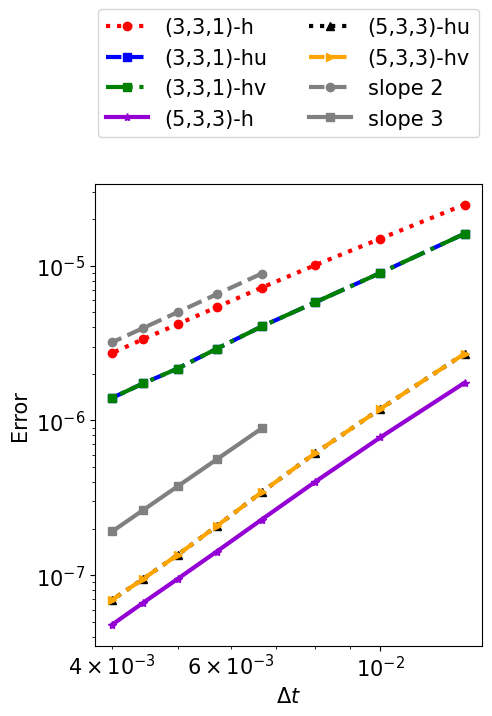

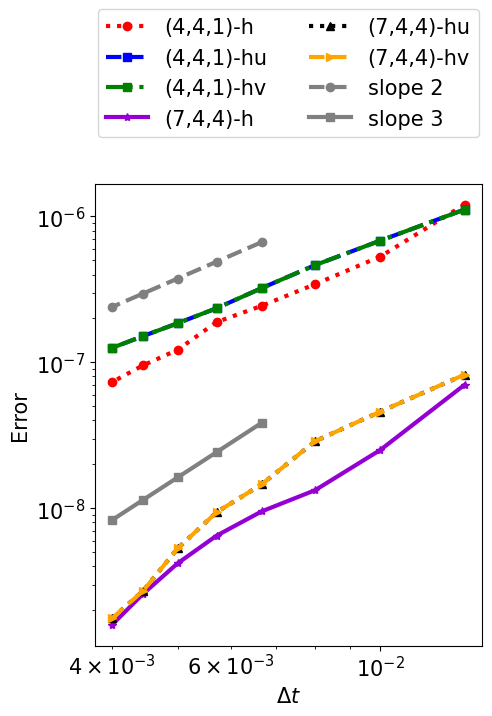

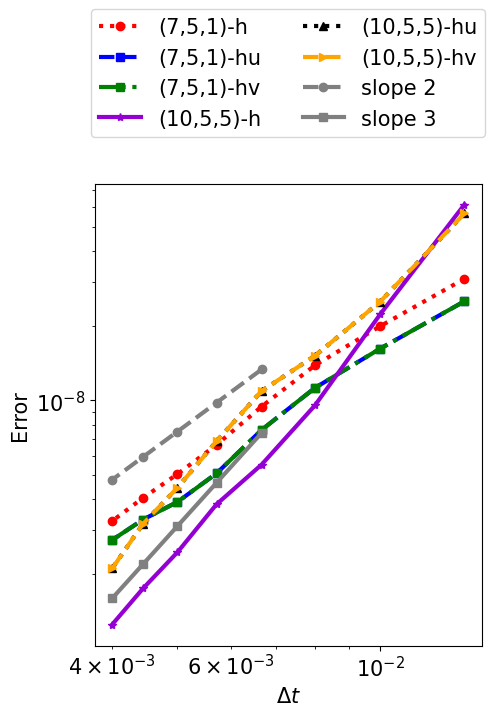

In [9]:
#plotting
Marks = ['o','s','+','*','^','>']
lines = [":","--","-.","-",":","--"]
colors = ["red", "blue", "green" ,"darkviolet","black","orange"]

Sl = [2,3,2,3,2,3]; Coeff = [2e-1,3e-0,1.5e-2,1.3e-1,3e-4,2.5e-2]

font = {#'family' : 'normal',
'weight' : 'normal',
'size'   : 15}
plt.rc('font', **font)

st = 3; en = 8;

for i in range(3):
    fig = plt.figure(figsize = (5, 6))
    plt.plot(dts,Err_u[2*i,:],color=colors[0], marker=Marks[0], linestyle=lines[0],linewidth=3,label = "(%d,%d,%d)-h"%(S[2*i],P[2*i],Q[2*i]))
    plt.plot(dts,Err_hu[2*i,:],color=colors[1], marker=Marks[1], linestyle=lines[1],linewidth=3,label = "(%d,%d,%d)-hu"%(S[2*i],P[2*i],Q[2*i]))
    plt.plot(dts,Err_hv[2*i,:],color=colors[2], marker=Marks[1], linestyle=lines[2],linewidth=3,label = "(%d,%d,%d)-hv"%(S[2*i],P[2*i],Q[2*i]))

    plt.plot(dts,Err_u[2*i+1,:],color=colors[3], marker=Marks[3], linestyle=lines[3],linewidth=3,label = "(%d,%d,%d)-h"%(S[2*i+1],P[2*i+1],Q[2*i+1]))
    plt.plot(dts,Err_hu[2*i+1,:],color=colors[4], marker=Marks[4], linestyle=lines[4],linewidth=3,label = "(%d,%d,%d)-hu"%(S[2*i+1],P[2*i+1],Q[2*i+1]))
    plt.plot(dts,Err_hv[2*i+1,:],color=colors[5], marker=Marks[5], linestyle=lines[5],linewidth=3,label = "(%d,%d,%d)-hv"%(S[2*i+1],P[2*i+1],Q[2*i+1]))

    plt.plot(dts[st:en],Coeff[2*i]*dts[st:en]**Sl[2*i], "--o", color="gray",linewidth=3,label='slope %d'%(Sl[2*i]))
    plt.plot(dts[st:en], Coeff[2*i+1]*dts[st:en]**Sl[2*i+1], "-s", color="gray",linewidth=3,label='slope %d'%(Sl[2*i+1]))

    plt.xscale("log"); plt.yscale("log"); plt.xlabel('$\Delta t$'); plt.ylabel('Error')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.4),ncol=2)
   